# Modelling the non-agentitivity alternation

## Fixed effects model

### Importing libraries

In [1]:
library(lme4)
library(glue)
library(performance)
library(rstudioapi)
library(broom)
library(scales)
library(sjPlot)
library(ggplot2)
library(dplyr)
library(dplyr)
library(stargazer)
library(broom.mixed)

Lade nötiges Paket: Matrix

Learn more about sjPlot with 'browseVignettes("sjPlot")'.


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




### Loading and preprocessing data

Treatment coding of response variable: "dezember " = 0, "zwölf" = 1

In [13]:
data <- read.csv("VACC/nonagentivity_for_analysis.csv")
data$CURRENT <- as.factor(data$CURRENT)
cat("R models this level:", tail(levels(data$CURRENT), 1))

R models this level: werden

In [14]:
#renaming speakers for consistency with the rest of the study
data <- data %>% mutate(PREVIOUS_SPEAKER = recode(PREVIOUS_SPEAKER, "A" = "VA", "S" = "HS", "J" = "CF"))

Combining the variables PREVIOUS and PREVIOUS_SPEAKER as modelling an interaction of these two independent variables leads to an issue of singularity

In [15]:
data$PREVIOUS_SPEAKER_COMBINED <- interaction(data$PREVIOUS, data$PREVIOUS_SPEAKER) #R automatically creates a factor
cat("Levels are:", levels(data$PREVIOUS_SPEAKER_COMBINED))
table(data$PREVIOUS_SPEAKER_COMBINED)

Levels are: man.CF werden.CF man.HS werden.HS man.VA werden.VA


   man.CF werden.CF    man.HS werden.HS    man.VA werden.VA 
       38        24        29        59         0        20 

Dropping the empty level "man.A".

In [17]:
data$PREVIOUS_SPEAKER_COMBINED <- droplevels(data$PREVIOUS_SPEAKER_COMBINED)
#before renaming (see above) "werden.A" was the reference level as it is first in alphabetical order, 
#to preserve this even after renaming, the factor is relevelled 
data$PREVIOUS_SPEAKER_COMBINED <- relevel(data$PREVIOUS_SPEAKER_COMBINED, ref = "werden.VA")
cat("The reference level of PREVIOUS_SPEAKER_COMBINED is:", head(levels(data$PREVIOUS_SPEAKER_COMBINED), 1)) 

The reference level of PREVIOUS_SPEAKER_COMBINED is: werden.VA

Treatment coding of further predictor variables

In [18]:
data$PREVIOUS <- as.factor(data$PREVIOUS)
data$PREVIOUS_BETA_MAN <- as.factor(data$PREVIOUS_BETA_MAN) 
data$PREVIOUS_BETA_WERDEN <- as.factor(data$PREVIOUS_BETA_WERDEN) 

### Data inspection

Overview of the data

In [19]:
head(data)

,X,CURRENT,PREVIOUS,PREVIOUS_SPEAKER,PREVIOUS_DISTANCE,PREVIOUS_DISTANCE_LOG,PREVIOUS_BETA_MAN,PREVIOUS_BETA_WERDEN,QUASI_PERSISTENCE,HUMAN_ID,INTERACTION_ID,TURN_LENGTH,CONFEDERATE,PREVIOUS_SPEAKER_COMBINED
,<int>,<fct>,<fct>,<chr>,<int>,<dbl>,<fct>,<fct>,<chr>,<chr>,<int>,<int>,<chr>,<fct>
1,1854,werden,man,CF,10,2.302585,False,False,False,20171121A,4,10,True,man.CF
2,1873,werden,werden,HS,19,2.944439,False,True,False,20171121A,4,7,True,werden.HS
3,4057,werden,man,HS,8,2.079442,False,False,False,20171121B,8,24,True,man.HS
4,4176,werden,werden,CF,14,2.639057,True,False,False,20171121B,8,6,True,werden.CF
5,4879,werden,man,CF,503,6.220590,False,True,False,20171121B,8,42,True,man.CF
6,4989,werden,werden,VA,19,2.944439,False,False,True,20171121B,8,8,True,werden.VA


Distribution of choices in CURRENT

In [20]:
data %>% count(CURRENT)

CURRENT,n
<fct>,<int>
man,51
werden,119


Distribution of PREVIOUS

In [21]:
data %>% count(PREVIOUS_SPEAKER_COMBINED, CURRENT)

PREVIOUS_SPEAKER_COMBINED,CURRENT,n
<fct>,<fct>,<int>
werden.VA,man,1
werden.VA,werden,19
man.CF,man,19
man.CF,werden,19
werden.CF,man,1
werden.CF,werden,23
man.HS,man,16
man.HS,werden,13
werden.HS,man,14


### Model fitting

In [22]:
fixed_effects_model <- glm(CURRENT ~ PREVIOUS_SPEAKER_COMBINED,
                                data = data, family = 'binomial')

summary(fixed_effects_model)


Call:
glm(formula = CURRENT ~ PREVIOUS_SPEAKER_COMBINED, family = "binomial", 
    data = data)

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)   
(Intercept)                          2.9444     1.0259   2.870  0.00410 **
PREVIOUS_SPEAKER_COMBINEDman.CF     -2.9444     1.0760  -2.736  0.00621 **
PREVIOUS_SPEAKER_COMBINEDwerden.CF   0.1911     1.4476   0.132  0.89500   
PREVIOUS_SPEAKER_COMBINEDman.HS     -3.1521     1.0918  -2.887  0.00389 **
PREVIOUS_SPEAKER_COMBINEDwerden.HS  -1.7768     1.0706  -1.660  0.09698 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 207.69  on 169  degrees of freedom
Residual deviance: 173.48  on 165  degrees of freedom
AIC: 183.48

Number of Fisher Scoring iterations: 5


#### Model evaluation

In [23]:
#Events per predictor
events <- sum(data$CURRENT == "man") #Number of positive cases
predictors <- length(coef(fixed_effects_model)) - 1 #Exclude intercept
EPP <- events / predictors
print(EPP)

[1] 12.75


In [24]:
r2_nagelkerke(fixed_effects_model)
AIC(fixed_effects_model)

Nagelkerke's R2 
       0.258467

[1] 183.4815

Model evaluation using predictive efficiency comparing how well the model fares at predicting the data it was fitted on compared to a 'dumb' intercept-only model only ever predicting the most frequent outcome

In [25]:
#Predictive efficiency
fixed_model_predictions <- predict(fixed_effects_model, newdata = data, type = "response")
#Convert probabilities to binary outcomes (i.e., if probability > 0.5, predict 1, else 0)
fixed_model_predicted_class <- ifelse(fixed_model_predictions > 0.5, "werden", "man")
#Compare predicted values to actual values
fixed_model_accuracy <- mean(fixed_model_predicted_class == data$CURRENT)
fixed_model_accuracy

[1] 0.7176471

In [26]:
#Calculate baseline accuracy, i.e., a dumb intercept-only model only ever predicting the most frequent outcome
counts <- table(data$CURRENT) 
dumb_model_accuracy <- max(counts) / sum(counts)
dumb_model_accuracy

[1] 0.7

In [27]:
#McNemar's Test for significance against baseline
baseline_predicted_class <- rep(names(which.max(counts)), length(data$CURRENT))  #Create baseline predictions (always predict the most frequent outcome)
mcnemar_table <- table(
  model_correct = (fixed_model_predicted_class == data$CURRENT),
  baseline_correct = (baseline_predicted_class == data$CURRENT)) #Create a contingency table: Compare model and baseline predictions against actual values
mcnemar_result <- mcnemar.test(mcnemar_table) #Perform McNemar's Test
mcnemar_result


	McNemar's Chi-squared test with continuity correction

data:  mcnemar_table
McNemar's chi-squared = 0.059701, df = 1, p-value = 0.807


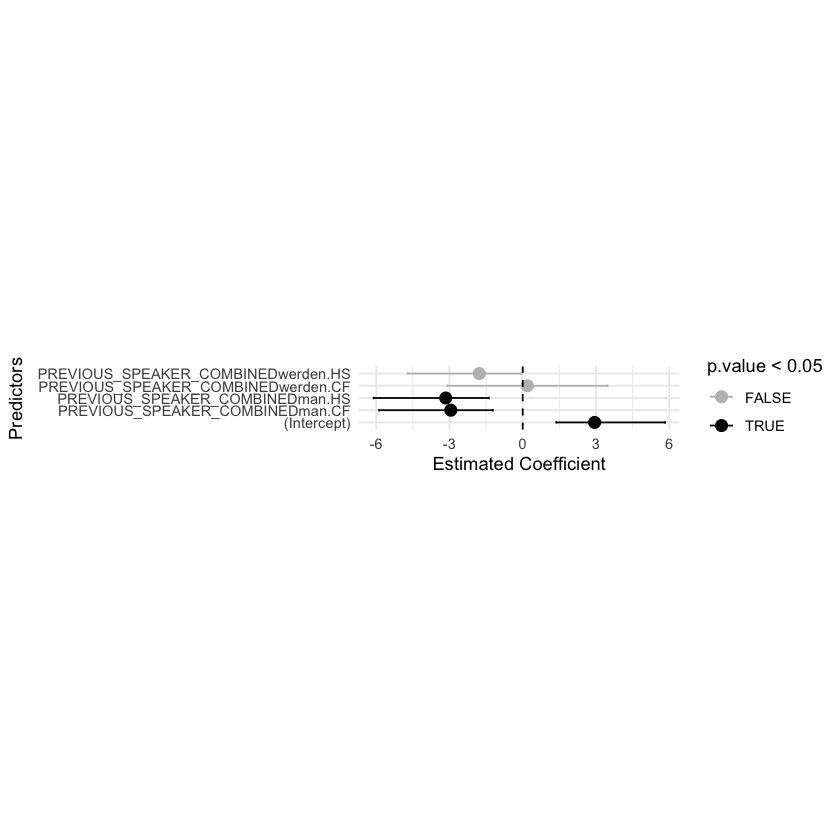

In [28]:
model_summary <- tidy(fixed_effects_model, conf.int = TRUE) 

plot <- ggplot(model_summary, aes(x = estimate, y = term, color = p.value < 0.05)) +
          geom_point(size = 3) +
                    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
          geom_vline(xintercept = 0, linetype = "dashed") +
          labs(
            x = "Estimated Coefficient",
            y = "Predictors",
          ) +
          theme_minimal() +
          scale_color_manual(values = c("TRUE" = "black", "FALSE" = "gray")) +  #Grey out non-significant predictors
          coord_fixed(ratio = 0.5)

ggsave("../../../publication/further/images/coefficient_non-agentivity.png", width = 10, height = 4,
       plot = plot, dpi = 300, bg = "white")

plot

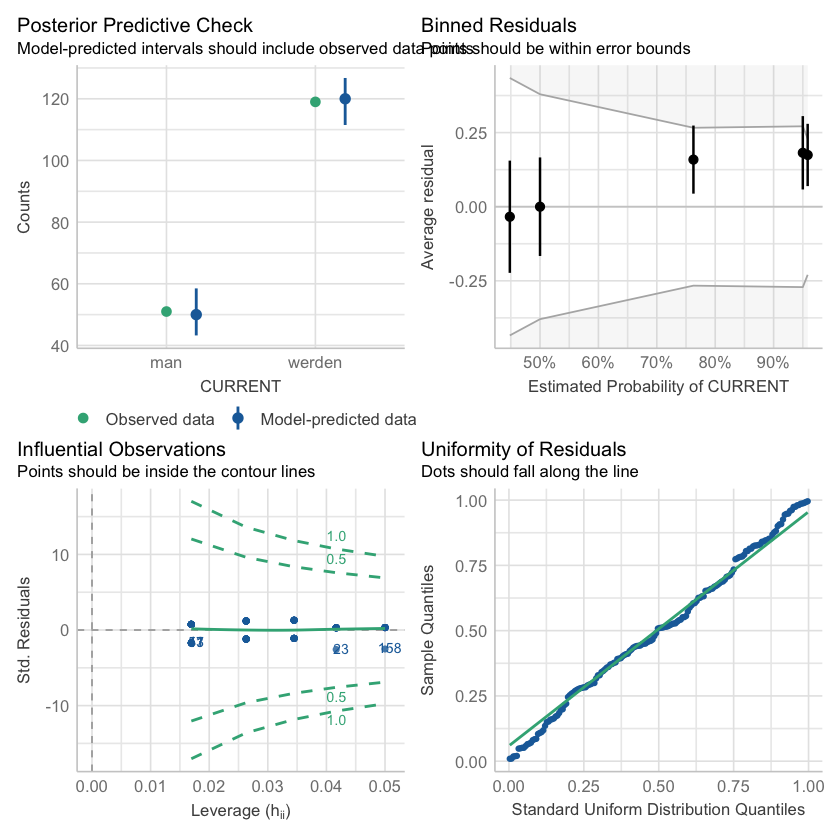

In [29]:
check_model(fixed_effects_model)

#### Visualisation

Plot visualises the probability of observing "werden" in CURRENT given different combinations of variants in PREVIOUS and SPEAKERS.

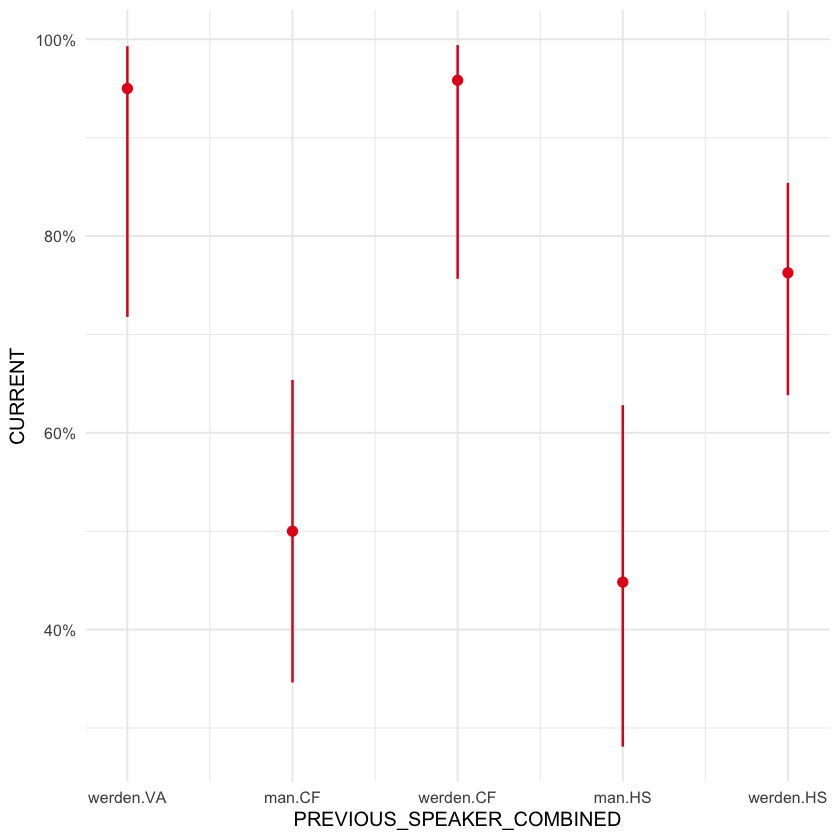

In [30]:
#for "werden" in CURRENT
plot <- plot_model(fixed_effects_model, type="pred", terms=c("PREVIOUS_SPEAKER_COMBINED"), dpi=300, ) + 
        theme(axis.text = element_text(size = 16), axis.title = element_text(size = 16)) + theme_minimal(base_size=12) +
        theme(plot.title = element_blank()) 

ggsave("../../../publication/further/images/prediction_plot_non-agentivity.png", plot = plot, width = 8, height = 6, dpi = 300)
plot

### Output

In [31]:
tab_model(fixed_effects_model, auto.label = FALSE, transform = NULL, show.aic = TRUE, file = "../../../publication/further/tables/model_non-agentivity.html")